# Exercises

---

## Exercise 1: structured and ustructured images
Write a function that outputs the number of PC you have to choose to retain a given percentage of explained variance.
Use this funtion on the  handwritten digit data, and plot the number of PC needed to retain a certain fraction of EVR, for a few vaules of EVR.

Compare this curve to the one you can obtain in unstructured images: either generate images with the same shape of our data or randomly permute the pixels in each image independenlty. How does the number of PC needed to retain a certain fraction of the variance in this case compare to the number needed for digit images?

In [1]:
import numpy as np
from scipy import io
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

In [2]:
def pc_number(data, percentage):
    # Z-score the data
    scaler = StandardScaler()
    X = scaler.fit_transform(data)
    
    # Perform PCA
    pca = PCA()
    pca.fit(X)
    
    # Check for which N components the cumulative EVR exceeds the given percentage
    # Because the array is zero-indexed, we add 1 to the number of PCs needed
    cumsum_evr = np.cumsum(pca.explained_variance_ratio_)
    for index, evr in enumerate(cumsum_evr):
        if evr >= percentage:
            return index+1

Number of PCs needed to retain 90% explained variance: 31


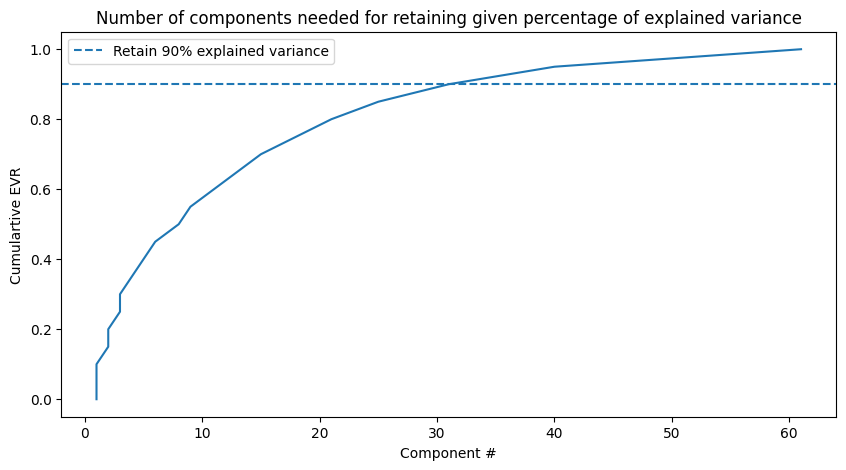

In [3]:
# Load handwritten digit image data
dataset = load_digits()
images = dataset.data

# Apply function for different percentages 
percentages = np.linspace(0, 1, num=21)
pcs = []
for percentage in percentages:
    pc = pc_number(images, percentage)
    pcs.append(pc)

# Plot the number of PC needed to retain fraction of EVR
plt.figure(figsize=(10,5))
plt.title('Number of components needed for retaining given percentage of explained variance')
plt.xlabel('Component #')
plt.ylabel('Cumulartive EVR')
plt.plot(pcs, percentages)
plt.axhline(y=0.9,linestyle='--', label='Retain 90% explained variance')

plt.legend()
plt.plot()

print('Number of PCs needed to retain 90% explained variance:', pc_number(images, 0.9))

Number of PCs needed to retain 90% explained variance MNIST data: 31
Number of PCs needed to retain 90% explained variance permuted data: 56


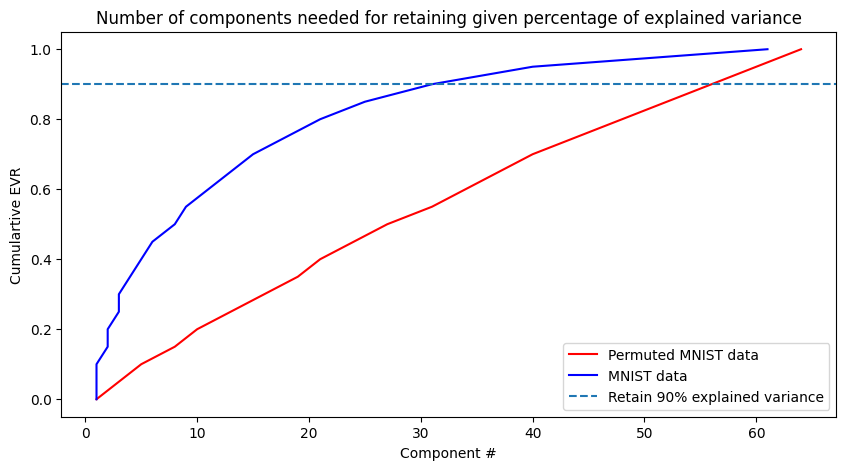

In [4]:
# Randomly permute pixels for each image in MNIST data
permuted_images = np.empty(images.shape)

for i in range(images.shape[0]):
    permuted_images[i] = np.random.permutation(images[i])

# Apply function for different percentages on permuted images
percentages = np.linspace(0, 1, num=21)
pcs_permuted = []
for percentage in percentages:
    pc_permuted = pc_number(permuted_images, percentage)
    pcs_permuted.append(pc_permuted)

# Plot the number of PC needed to retain fraction of EVR
plt.figure(figsize=(10,5))
plt.title('Number of components needed for retaining given percentage of explained variance')
plt.xlabel('Component #')
plt.ylabel('Cumulartive EVR')
plt.plot(pcs_permuted, percentages, color='r', label='Permuted MNIST data')
plt.plot(pcs, percentages, color='b', label='MNIST data')
plt.axhline(y=0.9,linestyle='--', label='Retain 90% explained variance')

plt.legend()
plt.plot()

print('Number of PCs needed to retain 90% explained variance MNIST data:', pc_number(images, 0.9))
print('Number of PCs needed to retain 90% explained variance permuted data:', pc_number(permuted_images, 0.9))

### Comments exercise 1:

In the plot above it can be seen that there is a significant difference in the amount of principal components that are needed to retain 90% of the explained variance for the MNIST data and the permuted MNIST data. In the case that the data is structured (the MNIST handwritten images) around half of the PCs are needed to retain 90% of the explained variance (31 to be exact). In comparison, the unstructured data (permuted MNIST images) need 55 PCs to retain 90% of the explained variance. This seems logical as unstructured has more complex patterns that are hard to distinguish due to the fact that there is a lot of noise added to the data and distinct patterns are hard to find.

## Exercise 2: cortical dynamics

Work with the cortical data we used in the lesson. Write some code that lets you easily chose a specific behavioural event from the `trial_data` dictionary (the recorded events are `CSp` for positive conditioned stimulus, `CSn` for negative conditioned stimulus and `licks` for lick events), one of the principal components, an onset time and and offset time, and plots the timecourse of this component in the selected period around the chosen event type.

Use this code to explore the data: how do different components behave? Do you notice any patterns? How would you test for the statistical significance of the effects that you see (if any)?

In [28]:
import pickle
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d

with open('./data/behaviour.pickle', 'rb') as handle:
    trial_data = pickle.load(handle)

voltage_signal = np.load('./data/voltage_signal.npy')
cortex_mask = np.load('./data/cortex_mask.npy')

X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:,cortex_mask] # select only cortex pixels, returns a flattened image

In [6]:
def cortical_pc(voltage_data, trial_data, event, num_pc, start, end):
    # Perform PCA
    pca = PCA(n_components=50)
    cortical_pca = pca.fit(voltage_data)
    
    # Select the principal component and compute PC timecourse
    PC = cortical_pca.components_[num_pc-1, :].T
    Y = voltage_data @ PC
    
    # Frame times
    framerate = 50. # in Hz
    frame_times = trial_data['frames']
    
    list_Y = [] #empty list for timecourses
    
    # Cycle over the event onsets
    for i in trial_data[event]:
        onset_frame = np.argmin(abs(frame_times-i)) #take frame closest to onset
        start_frame = int(onset_frame + framerate*start/1.000) # compute starting frame
        end_frame = int(onset_frame + framerate*end/1.000) # compute ending frame
        list_Y.append(Y[start_frame:end_frame]) #saves the slice of Y

    list_Y = np.asarray(list_Y) 

    mean_Y = np.mean(list_Y,axis=0) #average over events
    error = sem(list_Y,axis=0) #compute sem over events
    
    plt.figure(figsize=(4,2))
    t = np.linspace(start,end,int((end-start)*framerate))
    y = mean_Y
    err = error

    y = gaussian_filter1d(y,2)
    err = gaussian_filter1d(err,2)

    plt.plot(t,y)
    plt.fill_between(t,y-err,y+err,alpha=0.2)

    plt.xlabel('Time (s)')
    plt.ylabel(f'PC activation (a.u.) PC={num_pc}')

    plt.axvline(x=0,linestyle='--',label=f'{event} onset')
    plt.legend()
    
    return mean_Y, error

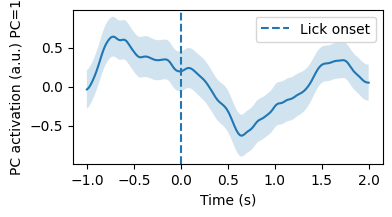

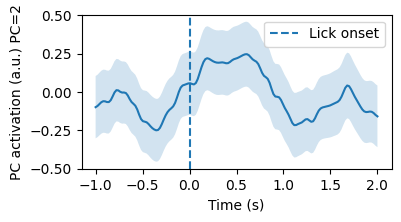

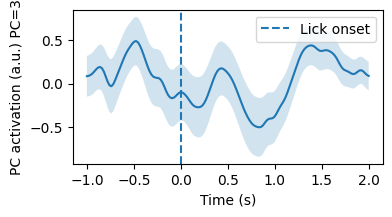

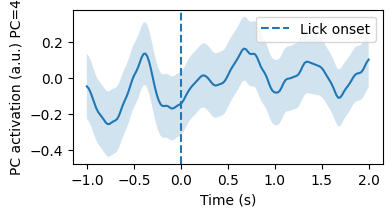

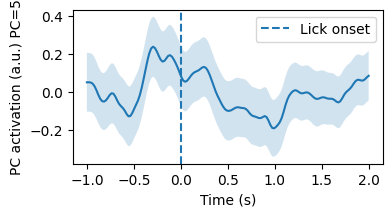

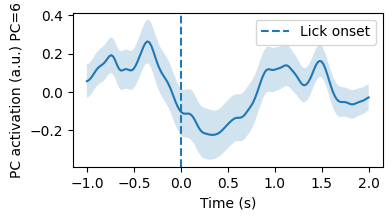

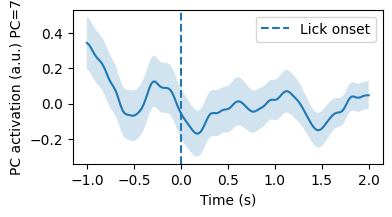

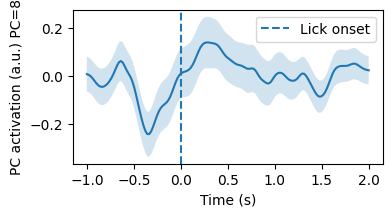

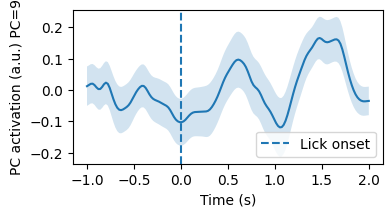

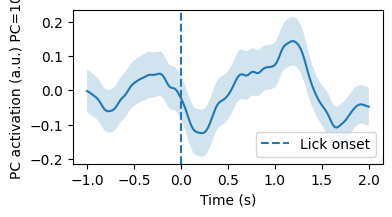

In [7]:
start_time = -1. 
end_time = 2. 
event_lick = 'Lick'
pc_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
framerate = 50.

for num in pc_numbers:
    mean, error = cortical_pc(X, trial_data, event_lick, num, start_time, end_time)

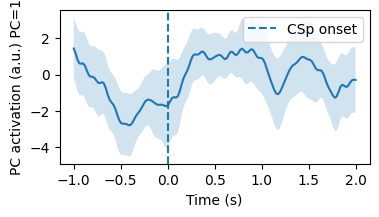

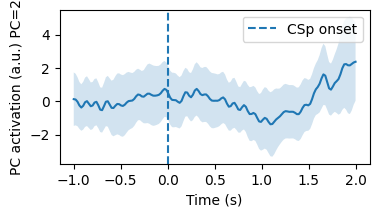

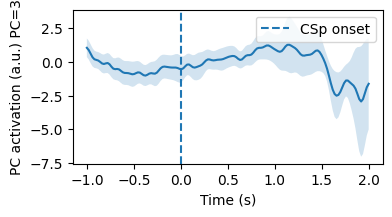

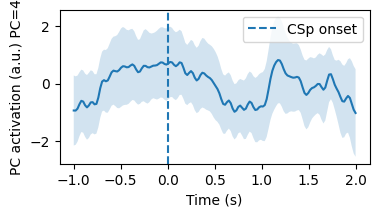

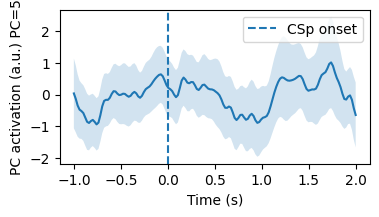

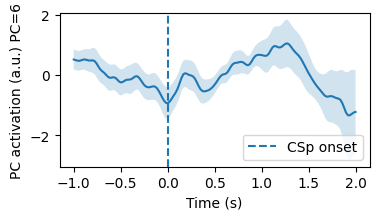

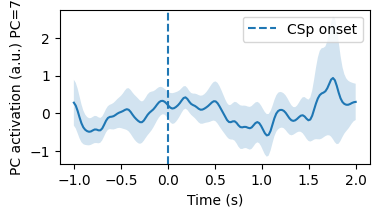

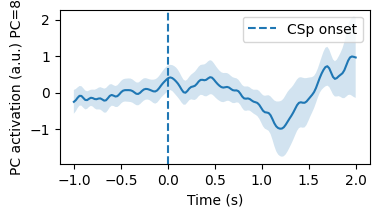

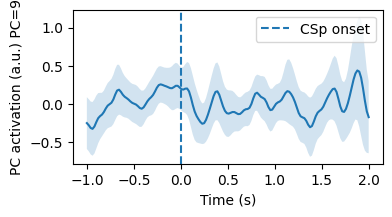

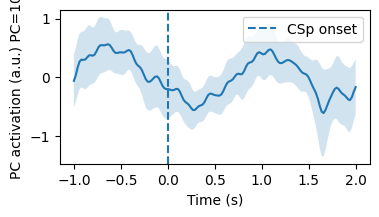

In [8]:
start_time = -1. 
end_time = 2. 
event_csp = 'CSp'
pc_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
framerate = 50.

for num in pc_numbers:
    mean, error = cortical_pc(X, trial_data, event_csp, num, start_time, end_time)

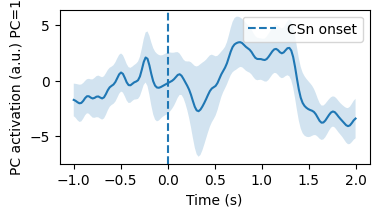

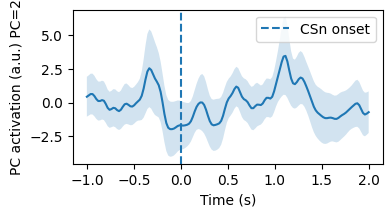

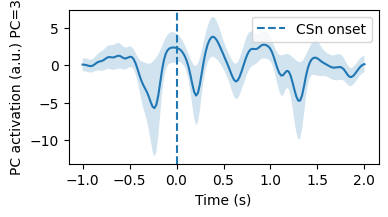

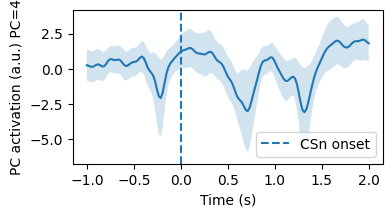

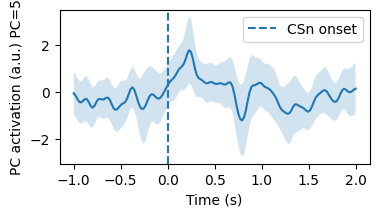

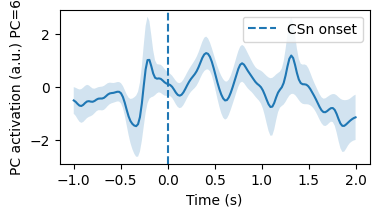

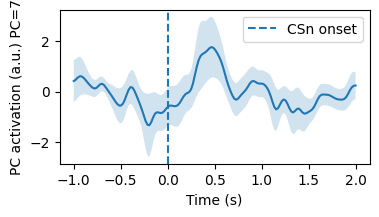

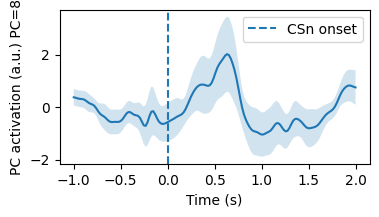

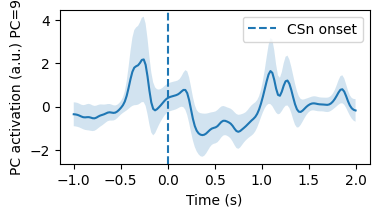

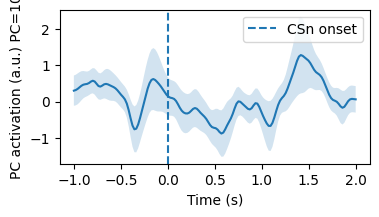

In [160]:
start_time = -1. 
end_time = 2. 
event_csn = 'CSn'
pc_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
framerate = 50.

for num in pc_numbers:
    mean, error = cortical_pc(X, trial_data, event_csn, num, start_time, end_time)

### Comments exercise 2:
For some of the components the PC activation goes up just before the event onset, for example PC=6 with lick onset. For other components the PC activation can go down before the event onset, for example PC=2 and PC=8 with lick onsets. A pattern can be seen in the PC=2 with lick onset. 


To test for statistical significance of the effects for a certain event, the PC activation in a stable condition (without an event onset) could be compared to the activation just before, during or after the event onset. To see if this change in activation is not random but has to do with the event, the data could be randomyl shuffled to see if the results of PC activation will still show the same patterns or not. 

## Exercise 3: nonlinear dimensionality reduction

Using the MNIST digit dataset, explore the effect of hyperparameters on the result of nonlinear dimensionality reduction methods.

- Change the `perplexity` and `exageration` parameters in `TNSE` (one at a time). Graphically compare the results of different values.
- Change the neighbourhood size in `Isomap` (set by the parameter `n_neighbors`), and visualize how the results change.

Finally, try to apply one or more of these methods to the cortical data we used in the lessons. How do the data look in two dimensions? Do any cluster seem to appear? Are they robust with respect to hyperparameter choice?

In [2]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

# load and preprocess data
dataset = load_digits()
images = dataset.data
X = StandardScaler().fit_transform(images)

# initialize embedding calculator
tsne10 = TSNE(n_components=2,random_state=0, perplexity=10)
tsne30 = TSNE(n_components=2,random_state=0, perplexity=30)
tsne50 = TSNE(n_components=2,random_state=0, perplexity=50)

#fit emebddings and transform data
X_tsne10 = tsne10.fit_transform(X)
X_tsne30 = tsne30.fit_transform(X)
X_tsne50 = tsne50.fit_transform(X)

Text(0, 0.5, 'X2')

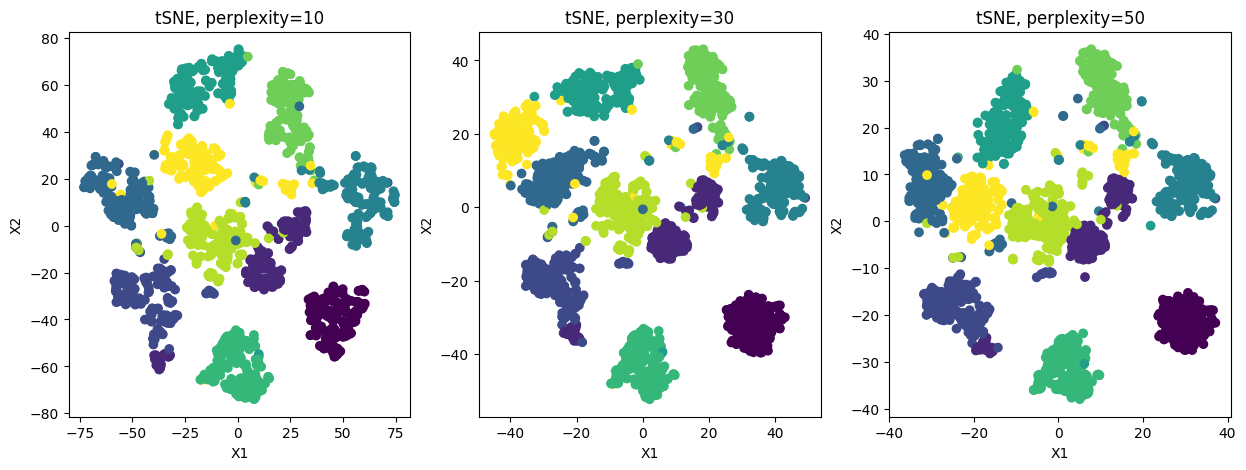

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_tsne10[:,0],X_tsne10[:,1],c=dataset.target)
plt.title('tSNE, perplexity=10')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_tsne30[:,0],X_tsne30[:,1],c=dataset.target)
plt.title('tSNE, perplexity=30')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_tsne50[:,0],X_tsne50[:,1],c=dataset.target)
plt.title('tSNE, perplexity=50')
plt.xlabel('X1')
plt.ylabel('X2')

In [3]:
# initialize embedding calculator
tsne6 = TSNE(n_components=2,random_state=0, early_exaggeration=6)
tsne12 = TSNE(n_components=2,random_state=0, early_exaggeration=12)
tsne18 = TSNE(n_components=2,random_state=0, early_exaggeration=18)

#fit emebddings and transform data
X_tsne6 = tsne6.fit_transform(X)
X_tsne12 = tsne12.fit_transform(X)
X_tsne18 = tsne18.fit_transform(X)

Text(0, 0.5, 'X2')

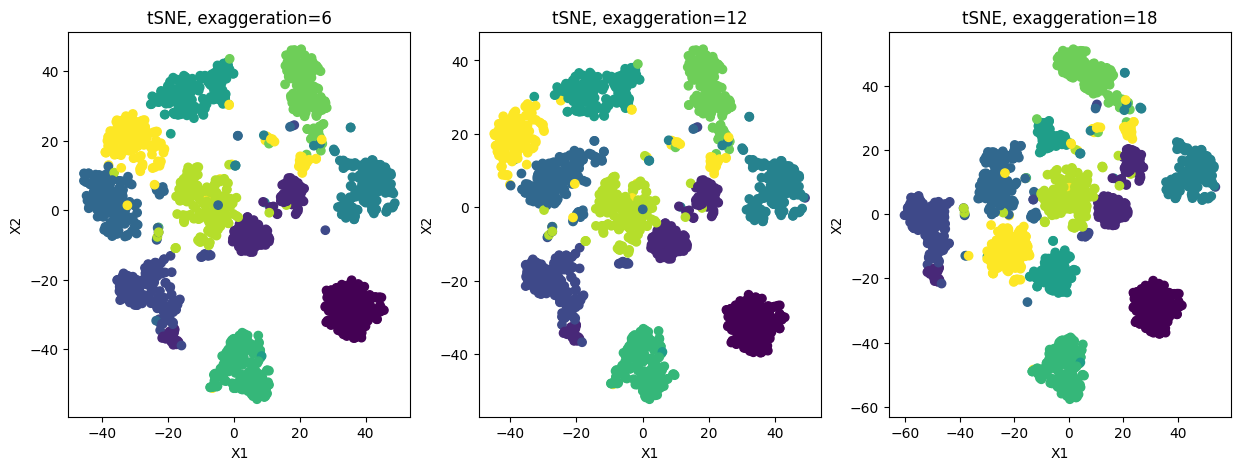

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_tsne6[:,0],X_tsne6[:,1],c=dataset.target)
plt.title('tSNE, exaggeration=6')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_tsne12[:,0],X_tsne12[:,1],c=dataset.target)
plt.title('tSNE, exaggeration=12')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_tsne18[:,0],X_tsne18[:,1],c=dataset.target)
plt.title('tSNE, exaggeration=18')
plt.xlabel('X1')
plt.ylabel('X2')

In [4]:
# initialize embedding calculator
isomap5 = Isomap(n_components=2, n_neighbors=5)
isomap10 = Isomap(n_components=2, n_neighbors=10)
isomap20 = Isomap(n_components=2, n_neighbors=20)

#fit emebddings and transform data
X_iso5 = isomap5.fit_transform(X)
X_iso10 = isomap10.fit_transform(X)
X_iso20 = isomap20.fit_transform(X)

Text(0, 0.5, 'X2')

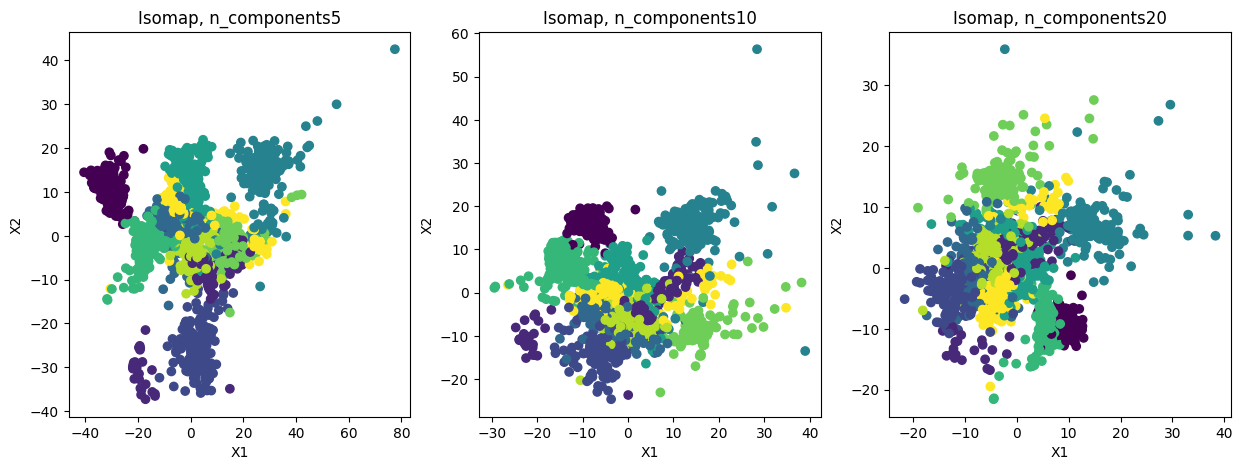

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_iso5[:,0],X_iso5[:,1],c=dataset.target)
plt.title('Isomap, n_components5')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_iso10[:,0],X_iso10[:,1],c=dataset.target)
plt.title('Isomap, n_components10')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_iso20[:,0],X_iso20[:,1],c=dataset.target)
plt.title('Isomap, n_components20')
plt.xlabel('X1')
plt.ylabel('X2')

### Comments exercise 3:
From the description on sklearn: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. The perplexity must be less than the number of samples. 

When using the MNIST data, it can be seen that for different values for the perplexity, the clusters are still mostly in the same place and size. Except for the yellow cluster, most other clusters seem mostly in the same shape/ 

From the description on sklearn: Early_exaggeration controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. 

With the MNIST data, there is not a major difference in the shape and placement of the clusters when changing the exaggeration from 6 to 12. However when changing the exaggeration to 18 it is shown that the clusters shift away from the left top corner.

When changing the neighbourhood size in Isomap (from the description on sklearn: Number of neighbors to consider for each point) it can be seen that with a higher number of neigbours the clusters become closer to each other and will overlap more. 